# Тестовое задание по риск-аналитике

## Задача 1
 - Сейчас порог отсечения для первичных клиентов (1 займ) по скорингу 200, при этом уровень просрочки 30+ (дней) составляет 22,3%. Какой порог отсечения необходимо поставить чтобы добиться уровня просрочки 30+ равным 14%.
 - Используйте шаг скорингового балла = 50
 - Поясните целесообразность этотого шага.
 -  Визуализируйте ответ
## Задача 2
 - Найти способ снизить просрочку 90+ (дней) по всем категориям займов более чем на 70%
 - Визуализируйте ответ"
## Задача 3
 - Какие еще переменные из выгрузки, кроме скорингового балла, наиболее коррелируют с возвратностью первичных займов (1 займ). 
 - Визуализируйте ответ
 


## Загрузка и подготовка исходных данных



### Подключение необходимых для работы библиотек


In [39]:
#Импортиуем библиотеки для работы с данными 
import pandas as pd
import numpy as np
#Импортируем бибилиотtrb для построения графиков
import matplotlib.pyplot as plt 
import matplotlib.ticker as tck
import seaborn as sns
# Импортируем прочий функционал
import timeit
from IPython.core.display import HTML
from IPython.core.interactiveshell import InteractiveShell

# Задаем опцию отображения результатов расчетов в ячейках
pd.options.mode.chained_assignment = None

# Задаем формат отображения чисел с плавающей точкой в pandas
pd.set_option('display.float_format', '{:,.2f}'.format) 

# Задаем стиль графиков seaborn
sns.set_style('darkgrid')

Импортируем прочий функционал: 

In [3]:
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

### Создадим необходимые в работе функции: 


In [4]:
# Фунция для более удобного просмотра содержимого датафреймов:
def df_preview(df,number_of_rows=-1):
    if number_of_rows==-1:
        display(HTML(df.to_html()))
    else:    
        display(HTML(df.head(number_of_rows).to_html()))
        
# Функция для удобного построения карты корреляции:        

def cor_plot(df):
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(df.corr(), cmap= sns.color_palette(palette="RdBu"),linewidths=0.5,annot=True,ax=ax)

# Функция для удобного построения графика(барплот):
def bar_plot(df, x, y, title):
        fig, ax = plt.subplots(figsize=(15,10))
        sns.barplot(
            data=df,
            x=x,
            y=y,
            ax=ax
        ).set_title(
            title
        )



### Загрузка и оценка исходных данных 

Загрузим исходные данные и произведем их качественную и визуальную оценку: 


In [5]:
data = pd.read_excel(
    r'H:\Тестовые по поиску работы\Риск-аналитик\test_task.xlsx',
    sheet_name='Займы')

data.info()
df_preview(data, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11787 entries, 0 to 11786
Data columns (total 19 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   ID займа                                             11787 non-null  int64         
 1   id верификатора                                      11787 non-null  int64         
 2   Статус займа (4 - закрыт, 3 не выплачен)             11787 non-null  int64         
 3   Дата выдачи займа                                    11787 non-null  datetime64[ns]
 4   Дата закрытия                                        8989 non-null   datetime64[ns]
 5   Какой по счету займ у клиента                        11787 non-null  int64         
 6   Количество продлений срока погашения по этому займу  11787 non-null  int64         
 7   Возраст                                              11787 non-null  float64       
 

,ID займа,id верификатора,"Статус займа (4 - закрыт, 3 не выплачен)",Дата выдачи займа,Дата закрытия,Какой по счету займ у клиента,Количество продлений срока погашения по этому займу,Возраст,"Пол (0 - м, 1-ж)",Количество детей,Скоринговый балл Скиба,Регион проживания,Регион паспорт,Дата погашения,Итоговое дней просрочки,Наличие просрочки ЖКХ,Наличие просрочки по кредитным картам,Наличие неоплаченных штрафов ГИБДД,Наличие производства в ФССП
0,1,3,3,2019-09-24 14:37:56,NaT,3,1,32.42,0,1,183,Самарская обл.,Самарская обл.,2019-11-19,115,1.00,NaN,1.00,NaN
1,2,20,4,2019-09-24 15:08:01,2019-10-06 16:54:28,4,0,39.73,1,2,222,Московская обл.,Московская обл.,2019-10-06,0,NaN,NaN,NaN,1.00
2,3,3,4,2019-09-24 15:16:11,2019-11-13 19:16:09,10,0,43.51,1,1,422,Курская обл.,Курская обл.,2019-10-23,21,NaN,1.00,NaN,NaN
3,4,97,4,2019-09-24 15:25:08,2019-10-02 15:02:18,1,0,30.70,1,1,142,Мурманская обл.,Мурманская обл.,2019-10-02,0,NaN,1.00,NaN,1.00
4,5,97,4,2019-09-24 15:35:12,2019-10-29 10:44:37,1,0,37.00,0,2,441,Краснодарский край,Краснодарский край,2019-10-24,5,NaN,1.00,1.00,NaN
5,6,20,3,2019-09-24 15:40:37,NaT,2,0,22.92,1,0,181,Алтайский край,Алтайский край,2019-10-24,141,NaN,NaN,1.00,NaN
6,7,157,4,2019-09-24 15:45:14,2019-10-02 11:17:42,1,0,36.25,1,2,215,Пермский край,Пермский край,2019-10-08,0,NaN,NaN,NaN,NaN
7,8,20,4,2019-09-24 15:48:27,2019-09-26 09:24:52,3,0,29.04,1,1,142,Красноярский край,Красноярский край,2019-10-06,0,NaN,NaN,NaN,NaN
8,9,3,4,2019-09-24 15:57:25,2019-11-02 13:02:44,3,1,34.27,1,1,150,Кемеровская обл.,Кемеровская обл.,2019-10-27,0,NaN,1.00,NaN,NaN
9,10,20,4,2019-09-24 15:58:17,2019-10-21 16:16:22,2,1,46.00,1,0,156,Свердловская обл.,Свердловская обл.,2019-10-21,0,NaN,1.00,NaN,NaN


При первом взгляде на данные, сразу бросается в глаза: 
 - названия столбцов приведены на русском языке
 - названия столбцов приведены с большой буквы
 - названия столбцов приведены на русском языке
 - названия включают нежелательные знаки(скобки, тире, пробелы) 

Имеются несоответствующие типы данных для столбцов: 
 - столбец "Возраст" имеет тип данных float64, его необходимо перевести в int64

Имеются пропуски в категориальных признаках, а именно в столбцах: 
 - Наличие просрочки ЖКХ
 - Наличие просрочки по кредитным картам
 - Наличие неоплаченных штрафов ГИБДД
 - Наличие производства в ФССП
    
Произведем обработку выявленных проблем в данных: 

###  Перобработка данных

Для того, чтобы разом изправить все проблемы в названиях столбцов изменим их на правильные: 


In [6]:
data = data.set_axis(
    [
        'id_credit',
        'id_verificator',            
        'credit_status',
        'date_open_credit',
        'date_close_credit',
        'number_of_credit',
        'number_of_prolong',
        'age',
        'gender',
        'number_of_children',
        'scoring_point_skiba',
        'region_of_live',
        'passport_region',
        'maturity_date',
        'day_of_delay',
        'delay_gkh', 
        'delay_credit_card',
        'delay_gibdd',
        'delay_fssp' 
    ],
    axis = 'columns'
    )
df_preview(data, 3)

,id_credit,id_verificator,credit_status,date_open_credit,date_close_credit,number_of_credit,number_of_prolong,age,gender,number_of_children,scoring_point_skiba,region_of_live,passport_region,maturity_date,day_of_delay,delay_gkh,delay_credit_card,delay_gibdd,delay_fssp
0,1,3,3,2019-09-24 14:37:56,NaT,3,1,32.42,0,1,183,Самарская обл.,Самарская обл.,2019-11-19,115,1.00,NaN,1.00,NaN
1,2,20,4,2019-09-24 15:08:01,2019-10-06 16:54:28,4,0,39.73,1,2,222,Московская обл.,Московская обл.,2019-10-06,0,NaN,NaN,NaN,1.00
2,3,3,4,2019-09-24 15:16:11,2019-11-13 19:16:09,10,0,43.51,1,1,422,Курская обл.,Курская обл.,2019-10-23,21,NaN,1.00,NaN,NaN


Как видно из полученных данных, замена названий столбцов прошла успешно. 

### Замена типов данных столбца

Пришло время изменить тип данных в столбце с возрастом.

In [7]:
data.age = data.age.astype(int)
df_preview(data, 3)

,id_credit,id_verificator,credit_status,date_open_credit,date_close_credit,number_of_credit,number_of_prolong,age,gender,number_of_children,scoring_point_skiba,region_of_live,passport_region,maturity_date,day_of_delay,delay_gkh,delay_credit_card,delay_gibdd,delay_fssp
0,1,3,3,2019-09-24 14:37:56,NaT,3,1,32,0,1,183,Самарская обл.,Самарская обл.,2019-11-19,115,1.00,NaN,1.00,NaN
1,2,20,4,2019-09-24 15:08:01,2019-10-06 16:54:28,4,0,39,1,2,222,Московская обл.,Московская обл.,2019-10-06,0,NaN,NaN,NaN,1.00
2,3,3,4,2019-09-24 15:16:11,2019-11-13 19:16:09,10,0,43,1,1,422,Курская обл.,Курская обл.,2019-10-23,21,NaN,1.00,NaN,NaN


Заполним недастающие данные в столбцах. Недостоющие значения в категориальных столбцах заменим на 0(ноль) так как, при их заполнении 1(единица) ставилась при наличии у заемщика условия. При отсутствии условия поле оставлялось пустым. Поэтому заполнение пропусков нулями - в данном случае предпочтительно. 

In [8]:
data = data.fillna(0)
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11787 entries, 0 to 11786
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_credit            11787 non-null  int64         
 1   id_verificator       11787 non-null  int64         
 2   credit_status        11787 non-null  int64         
 3   date_open_credit     11787 non-null  datetime64[ns]
 4   date_close_credit    11787 non-null  object        
 5   number_of_credit     11787 non-null  int64         
 6   number_of_prolong    11787 non-null  int64         
 7   age                  11787 non-null  int32         
 8   gender               11787 non-null  int64         
 9   number_of_children   11787 non-null  int64         
 10  scoring_point_skiba  11787 non-null  int64         
 11  region_of_live       11787 non-null  object        
 12  passport_region      11787 non-null  object        
 13  maturity_date        11787 non-

In [9]:
df_preview(data, 3)

,id_credit,id_verificator,credit_status,date_open_credit,date_close_credit,number_of_credit,number_of_prolong,age,gender,number_of_children,scoring_point_skiba,region_of_live,passport_region,maturity_date,day_of_delay,delay_gkh,delay_credit_card,delay_gibdd,delay_fssp
0,1,3,3,2019-09-24 14:37:56,0,3,1,32,0,1,183,Самарская обл.,Самарская обл.,2019-11-19,115,1.00,0.00,1.00,0.00
1,2,20,4,2019-09-24 15:08:01,2019-10-06 16:54:28,4,0,39,1,2,222,Московская обл.,Московская обл.,2019-10-06,0,0.00,0.00,0.00,1.00
2,3,3,4,2019-09-24 15:16:11,2019-11-13 19:16:09,10,0,43,1,1,422,Курская обл.,Курская обл.,2019-10-23,21,0.00,1.00,0.00,0.00


Как видно из приведенных данных - пропуски заполненны. Проверим данные на наличие неявных дублей. У нас два столбца в которых возможно их появление - регион проживания и регион прописки: 


In [10]:
pd.Series(data['region_of_live'].unique()).sort_values()

69                  Адыгея респ.
32                   Алтай респ.
5                 Алтайский край
71                 Амурская обл.
13            Архангельская обл.
67             Астраханская обл.
21            Башкортостан респ.
37             Белгородская обл.
39                 Брянская обл.
40                 Бурятия респ.
63             Владимирская обл.
15            Волгоградская обл.
66              Вологодская обл.
31              Воронежская обл.
78                Дагестан респ.
80                Еврейская а.о.
23            Забайкальский край
60               Ивановская обл.
24                Иркутская обл.
79      Кабардино-Балкария респ.
64          Калининградская обл.
22                Калмыкия респ.
27                Калужская обл.
74               Камчатский край
43    Карачаево-Черкесская респ.
48                 Карелия респ.
8               Кемеровская обл.
61                Кировская обл.
36                    Коми респ.
76              Костромская обл.
4         

В столбце - с регионом проживания неявных дублей нет. Проверим столбец с регионом прописки таким же методом. 


In [11]:
pd.Series(data['passport_region'].unique()).sort_values()

73                  Адыгея респ.
35                   Алтай респ.
5                 Алтайский край
76                 Амурская обл.
13            Архангельская обл.
72             Астраханская обл.
22            Башкортостан респ.
40             Белгородская обл.
41                 Брянская обл.
42                 Бурятия респ.
30             Владимирская обл.
16            Волгоградская обл.
69              Вологодская обл.
34              Воронежская обл.
79                Дагестан респ.
26                Еврейская а.о.
24            Забайкальский край
64               Ивановская обл.
25                Иркутская обл.
50      Кабардино-Балкария респ.
68          Калининградская обл.
23                Калмыкия респ.
29                Калужская обл.
75               Камчатский край
46    Карачаево-Черкесская респ.
52                 Карелия респ.
8               Кемеровская обл.
65                Кировская обл.
39                    Коми респ.
78              Костромская обл.
4         

Как видно из приведенных выше данных - неявных дублей в столбцах нет. 

#### Вывод: 
Мы произвели предобработку данных в ходе которой: 
- изменили названия столбцов на более удобные для работы
- изменили тип данных столбца на правильный
- заполнили недастающие данные в столбцах
- проверили данные на наличие неявных дублей.

Пришло время изучить данные: 

## Анализ данных
### Проверка корреляции данных в отдельных столбцах
Построим график характеризующий корреляцию столбцов в нашем датафрейме: 

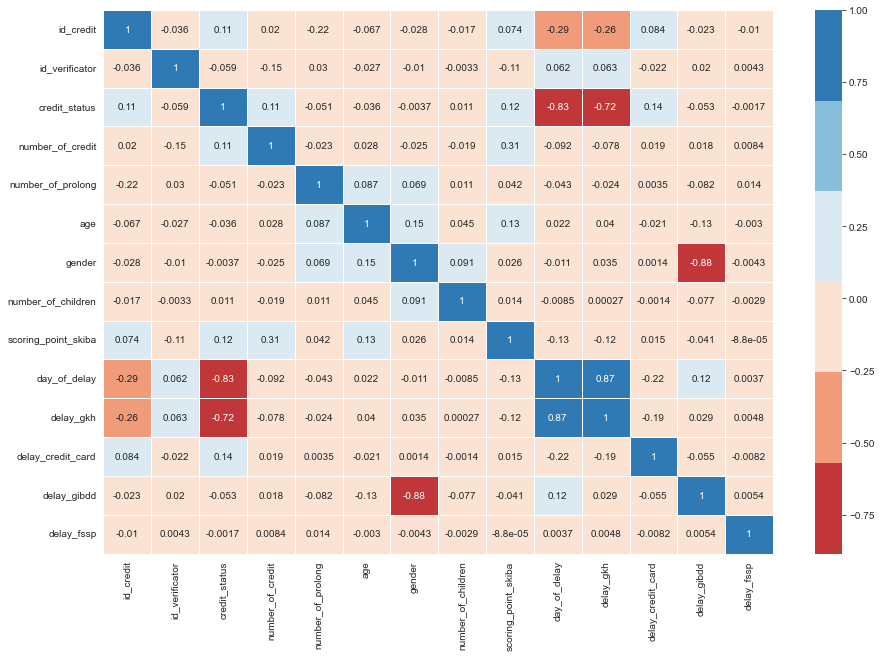

In [12]:
cor_plot(data)

Как видно из приведенного выше графика - все очень интересно, но не понятно.В сухом остатке: 
- Штрафы ГИБДД отрицательно коррелируют с полом - у нас два значения. То есть количество штрафов ожидаемо больше у мужской части населения. 
- отрицательная корреляция(то есть с увеличением одного признака - другой уменьшается) наблюдается у статуса предита(закрыт или нет) 
- также существует отрицательная корреляция со статусом кредита и долгами по ЖКХ(Потому как, человек в просрочке как правило отказывается от всех обязательных платежей) 
- Имется также корреляция между id кредита и просрочкой и долгами по ЖКХ, но смысловой нагрузки этот момент не несет. 

Теперь попробуем решить задачу № 1 

## Задача 1
- Сейчас порог отсечения для первичных клиентов (1 займ) по скорингу 200, при этом уровень просрочки 30+ (дней) составляет 22,3%. Какой порог отсечения необходимо поставить чтобы добиться уровня просрочки 30+ равным 14%.
- Используйте шаг скорингового балла = 50
- Поясните целесообразность этотого шага.
- Визуализируйте ответ

Сперва создадим срез данных для оценки первичных займов: 


In [13]:
credit_first = data.query('number_of_credit == 1')
credit_first.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5030 entries, 3 to 11786
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_credit            5030 non-null   int64         
 1   id_verificator       5030 non-null   int64         
 2   credit_status        5030 non-null   int64         
 3   date_open_credit     5030 non-null   datetime64[ns]
 4   date_close_credit    5030 non-null   object        
 5   number_of_credit     5030 non-null   int64         
 6   number_of_prolong    5030 non-null   int64         
 7   age                  5030 non-null   int32         
 8   gender               5030 non-null   int64         
 9   number_of_children   5030 non-null   int64         
 10  scoring_point_skiba  5030 non-null   int64         
 11  region_of_live       5030 non-null   object        
 12  passport_region      5030 non-null   object        
 13  maturity_date        5030 non-nu

Отлично - получился срез данных - как видно, количество первичных заявок составляет чуть менее половины от всех заявок.
Напишем функцию для подсчета 


In [14]:
def percent_dalay(df, day_dalay):
    return  len(df.loc[df['day_of_delay'] > day_dalay]) / len(df)

Теперь посчитаем количество просрочек 30+ от общего числа: 

In [15]:
credit_first_200_scr = credit_first.query('scoring_point_skiba >=200')

percent_dalay_200_scr = percent_dalay(credit_first_200_scr,30)
print('Процент просрочки 30+ при первичном кредите {:.2%}'.format(percent_dalay_200_scr))

Процент просрочки 30+ при первичном кредите 21.84%


Результат немного удивляет, так как отличается от заданного в задании, там указано, что значение - 22,3. Но на то мы и аналитики, чтобы проверять исходные данные.

Создадим итоговый датафрейм и добавим в него полученное значение: 

In [16]:
df_Result = pd.DataFrame(
    {
        'Порог скорринга,баллов':[], 
        'Процент просрочки 30+ дней,%':[]
    }
)

Добавим в конец полученное нами значение: 

In [17]:
df_Result = df_Result.append(
    {
        'Порог скорринга,баллов':200, 
        'Процент просрочки 30+ дней,%': percent_dalay_200_scr * 100 
    }
    , ignore_index=True
)
df_Result


,"Порог скорринга,баллов","Процент просрочки 30+ дней,%"
0,200.00,21.84


Теперь согласно задания понизим порог скоринга на 50 единиц и посмотрим, как снизится процент просрочек. Для этого создадим срез: 


In [18]:
credit_first_150_scr = credit_first.query('scoring_point_skiba <=150')
credit_first_150_scr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271 entries, 3 to 11784
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_credit            1271 non-null   int64         
 1   id_verificator       1271 non-null   int64         
 2   credit_status        1271 non-null   int64         
 3   date_open_credit     1271 non-null   datetime64[ns]
 4   date_close_credit    1271 non-null   object        
 5   number_of_credit     1271 non-null   int64         
 6   number_of_prolong    1271 non-null   int64         
 7   age                  1271 non-null   int32         
 8   gender               1271 non-null   int64         
 9   number_of_children   1271 non-null   int64         
 10  scoring_point_skiba  1271 non-null   int64         
 11  region_of_live       1271 non-null   object        
 12  passport_region      1271 non-null   object        
 13  maturity_date        1271 non-nu

Получили датафрейм, который в 3,5 раза меньше исходного с первичными кредитами. Посчитаем процент просрочек 30+

In [19]:
percent_dalay_150_scr = percent_dalay(credit_first_150_scr,30)
print('Процент просрочки 30+ при первичном кредите {:.2%}'.format(percent_dalay_150_scr))

Процент просрочки 30+ при первичном кредите 28.17%


Как видно из полученного результата, процент отказов при уменьшении скоринга на 50 единиц повысил количество просрочек на 4,5 процента. Запишем этот результат в нашу таблицу и попробуем увеличить исходную величину скоринга на 50 единиц. 

In [20]:
df_Result = df_Result.append(
    {
        'Порог скорринга,баллов':150, 
        'Процент просрочки 30+ дней,%': percent_dalay_150_scr * 100 
    }
    , ignore_index=True
)
df_Result

,"Порог скорринга,баллов","Процент просрочки 30+ дней,%"
0,200.00,21.84
1,150.00,28.17


In [21]:
credit_first_250_scr = credit_first.query('scoring_point_skiba >=250')
credit_first_250_scr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791 entries, 4 to 11777
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_credit            791 non-null    int64         
 1   id_verificator       791 non-null    int64         
 2   credit_status        791 non-null    int64         
 3   date_open_credit     791 non-null    datetime64[ns]
 4   date_close_credit    791 non-null    object        
 5   number_of_credit     791 non-null    int64         
 6   number_of_prolong    791 non-null    int64         
 7   age                  791 non-null    int32         
 8   gender               791 non-null    int64         
 9   number_of_children   791 non-null    int64         
 10  scoring_point_skiba  791 non-null    int64         
 11  region_of_live       791 non-null    object        
 12  passport_region      791 non-null    object        
 13  maturity_date        791 non-null

In [22]:
percent_dalay_250_scr = percent_dalay(credit_first_250_scr,30)
print('Процент просрочки 30+ при первичном кредите {:.2%}'.format(percent_dalay_250_scr))

Процент просрочки 30+ при первичном кредите 19.34%


In [23]:
df_Result = df_Result.append(
    {
        'Порог скорринга,баллов':250, 
        'Процент просрочки 30+ дней,%': percent_dalay_250_scr * 100 
    }
    , ignore_index=True
)
df_Result

,"Порог скорринга,баллов","Процент просрочки 30+ дней,%"
0,200.00,21.84
1,150.00,28.17
2,250.00,19.34


In [24]:
credit_first_300_scr = credit_first.query('scoring_point_skiba >=300')
percent_dalay_300_scr = percent_dalay(credit_first_300_scr,30)
print('Процент просрочки 30+ при первичном кредите {:.2%}'.format(percent_dalay_300_scr))

Процент просрочки 30+ при первичном кредите 17.79%


In [25]:
df_Result = df_Result.append(
    {
        'Порог скорринга,баллов':300, 
        'Процент просрочки 30+ дней,%': percent_dalay_300_scr * 100 
    }
    , ignore_index=True
)
df_Result.sort_values(by='Процент просрочки 30+ дней,%')

,"Порог скорринга,баллов","Процент просрочки 30+ дней,%"
3,300.00,17.79
2,250.00,19.34
0,200.00,21.84
1,150.00,28.17


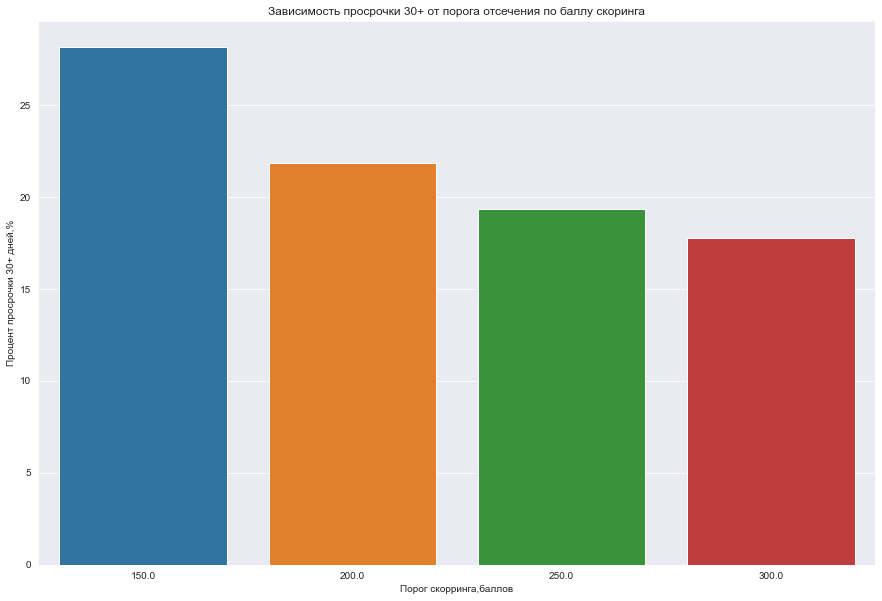

In [26]:
bar_plot(
    df_Result,
    "Порог скорринга,баллов",
    "Процент просрочки 30+ дней,%",
    'Зависимость просрочки 30+ от порога отсечения по баллу скоринга'
)

### Вывод:
- Мы добились поставленного в задаче процента просрочек в 17,79% благодаря установлению порога отсечения в 300 баллов(сделав 2 шага по 50 баллов в сторону увелечения)
- Данный шаг позволяет смягчить требования к заемщику и соответственно выдать большее количество кредитов. После чего, процент просрочек станет меньше. 
- Ответ визуализирован. 

## Задача 2
- Найти способ снизить просрочку 90+ (дней) по всем категориям займов более чем на 70%
- Визуализируйте ответ"

Для решения данной задачи, снова построим карту корреляции признаков: 

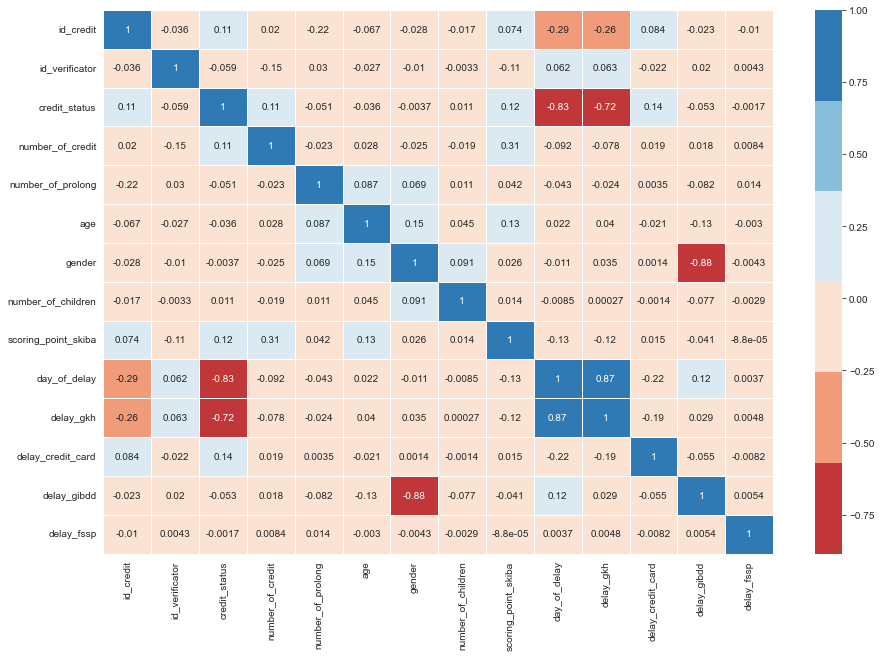

In [27]:
cor_plot(data)

Как видно из приведенных данных, более всего количество дней просрочки коррелирует с долгами по ЖКХ. Корреляция положительная, соответственно если в признаки Долга по ЖКХ стоит значение 1, то вероятность просрочки - более 80 процентов.

Создадим итоговый датафрейм для результатов исследований и последующей визуализации: 

In [28]:
df_Result_1 = pd.DataFrame(
    {
        'Данные':[], 
        'Процент просрочки 90+ дней,%':[]
    }
)

In [29]:
percent_dalay_90_day = percent_dalay(data, 90)
print('Процент просрочки 90+ при всех кредитах на общих данных: {:.2%}'.format(percent_dalay_90_day))

Процент просрочки 90+ при всех кредитах на общих данных: 8.39%


Запишем наши данные в итоговую таблицу: 


In [30]:
df_Result_1 = df_Result_1.append(
    {
        'Данные':'Общие данные', 
        'Процент просрочки 90+ дней,%':percent_dalay_90_day * 100
    }
    , ignore_index=True
)
df_Result_1

,Данные,"Процент просрочки 90+ дней,%"
0,Общие данные,8.39


Теперь создадим фильтр по отсутствию долгов по ЖКХ и посмотрим процент задолженностей 90+ в полученном срезе данных: 

In [31]:
data_not_dalay_gkh = data.query('delay_gkh != 1')
percent_dalay_90_day_not_gkh = percent_dalay(data_not_dalay_gkh, 90)
print(
    'Процент просрочки 90+ при всех кредитах при отсутсвии долгов ЖКХ:{:.2%}'
    .format(percent_dalay_90_day_not_gkh))

Процент просрочки 90+ при всех кредитах при отсутсвии долгов ЖКХ:0.36%


Запишим полученный результат в итоговую таблицу: 

In [32]:
df_Result_1 = df_Result_1.append(
    {
        'Данные':'Срез без долгов по ЖКХ', 
        'Процент просрочки 90+ дней,%': percent_dalay_90_day_not_gkh * 100
    }
    , ignore_index=True
)
df_Result_1

,Данные,"Процент просрочки 90+ дней,%"
0,Общие данные,8.39
1,Срез без долгов по ЖКХ,0.36


Построим график с результатами исследования:

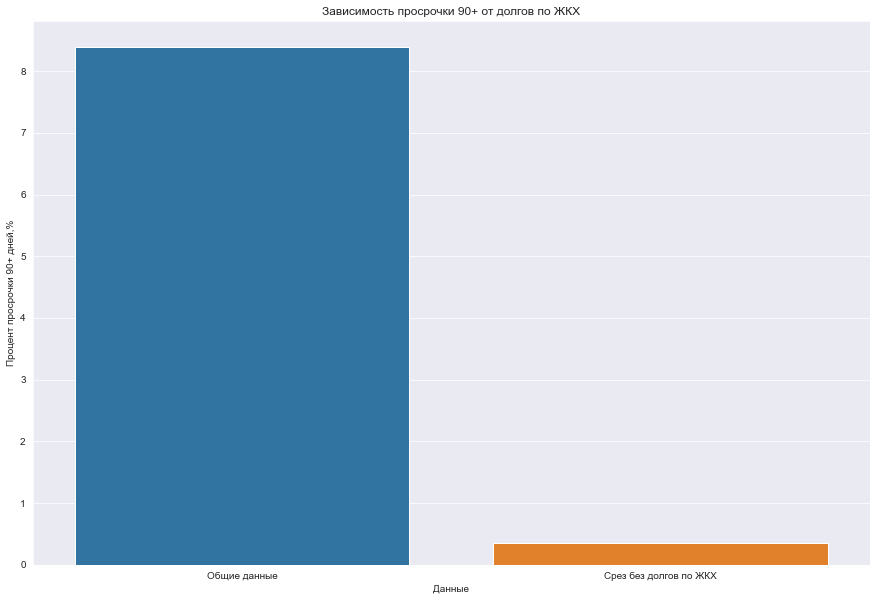

In [33]:
bar_plot(
    df_Result_1,
    'Данные',
    'Процент просрочки 90+ дней,%',
    'Зависимость просрочки 90+ от долгов по ЖКХ'
)

### Вывод: 
- Мы нашли параметр, который оказывает наибольшее влияние на наличие просрочки 90+ дней по всем займам - это наличие долга по ЖКХ. 
- Решение которое позволяет избежать просрочки 90+ дней - не выдавть займы людям имеющим долги по ЖКХ.


## Задача 3
- Какие еще переменные из выгрузки, кроме скорингового балла, наиболее коррелируют с возвратностью первичных займов (1 займ).
- Визуализируйте ответ

Создадим срез первичных кредитов и посмотрим корреляцию признаков друг с другом: 


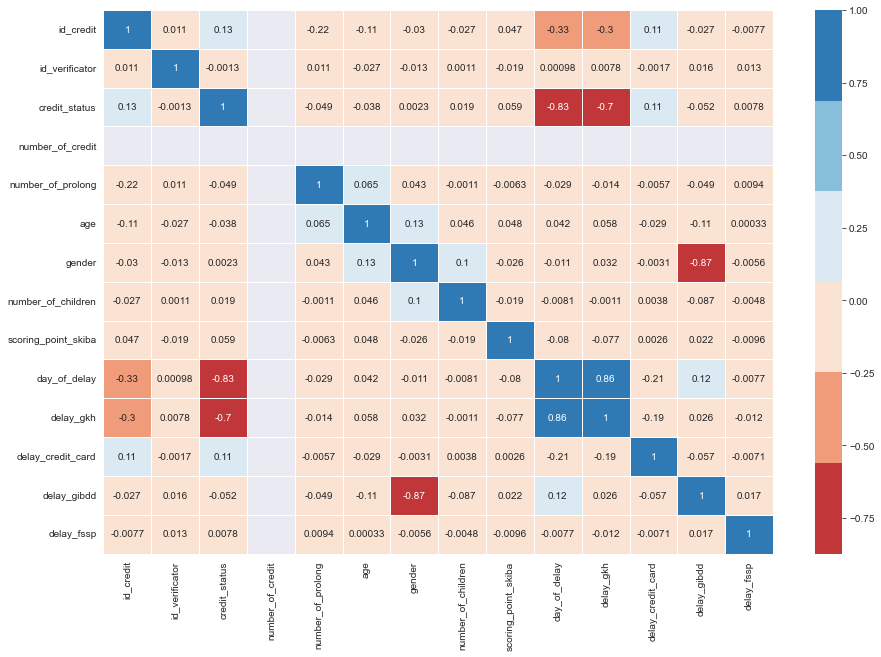

In [34]:
first_credit = data.query('number_of_credit == 1')
cor_plot(first_credit)

Для более наглядного примера построим таблицу корреляции по цветам

In [35]:
(
    data
    .corr()['credit_status']
    .to_frame()
    .sort_values('credit_status', ascending=False)
    .style
    .background_gradient(cmap='Greens')
)

,credit_status
credit_status,1.000000
delay_credit_card,0.136361
scoring_point_skiba,0.121196
number_of_credit,0.108987
id_credit,0.108034
number_of_children,0.011371
delay_fssp,-0.001693
gender,-0.003712
age,-0.036372
number_of_prolong,-0.051306


Как видно из приведенной выше таблицы, на возвратность кредитов влияет, помимо скорингового балла коррелирует наличие просрочки по кредитной крате, а также номер кредита.

### Вывод:
-Мы провели исследование корреляции возратности кредитов и других признаков - наиболее коррелируют просрочки по кредитной крате, а также порядковый номер кредита у клиента.

## Общий вывод: 

В ходе исследования решены все 3 задачи:

#### Задача 1:
- Мы добились поставленного в задаче процента просрочек в 17,79% благодаря установлению порога отсечения в 300 баллов(сделав 2 шага по 50 баллов в сторону увелечения)
- Данный шаг позволяет смягчить требования к заемщику и соответственно выдать большее количество кредитов. После чего, процент просрочек станет меньше. 
- Ответ визуализирован. 

#### Задача 2:

- Мы нашли параметр, который оказывает наибольшее влияние на наличие просрочки 90+ дней по всем займам - это наличие долга по ЖКХ. 
- Решение которое позволяет избежать просрочки 90+ дней - не выдавть займы людям имеющим долги по ЖКХ.

#### Задача 3:
- Мы провели исследование корреляции возратности кредитов и других признаков - наиболее коррелируют просрочки по кредитной крате, а также порядковый номер кредита у клиента.
- Результат визуализирован



